# Bilbo The Bot

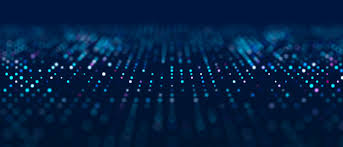

##  <a href='#1'>1. Introduction</a>  
##  <a href='#2'>2. Exploratory Data Analysis (EDA)</a>
##  <a href='#3'>3. Data Visualization</a>
##  <a href='#4'>4. Training the model</a>

### <a id='1'>1. Introduction</a>

This project aims to provide relevant articles for users interested in specific data science topics using Natural Language Processing (NLP) techniques with TensorFlow.

It builds a model that suggests a series of articles depending on the user input.

This project combines all the necessary skills for dealing with data:
* Exploratory Data Analysis
* Building Models
* Deploying output to production
* Making it accessible by using a public website

### If you need to contact me, don't be afraid:
* Email: **leonardo.sanchezsoler@gmail.com**
* Linkedin: **https://www.linkedin.com/in/leonardosanchezsoler/**

### Check my repo in Github: **https://github.com/leosanchezsoler**

### <a id='2'>2. Exploratory Data Analysis (EDA)</a>

In [35]:
### Import the necessary libraries ###

# READING FILES
import json # Module for reading json files

# EDA
import pandas as pd # High-performance module for data analysis
import numpy as np # Fundamental package for linear algebra
from src.utils.mining_data_tb import df_info, remove_cols, apply_function_to_cols # Self-made functions

# TEXT FORMATTING 
from ast import literal_eval # convert 'stringfield' lists to usable structure
import re # regex for text formatting and cleaning
from src.utils.text_formatting_tb import get_names, get_link, get_tag, apply_clean_text, remove_stop_words, create_embedding_matrix

# DATA VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from src.utils.visualization_tb import freq_words, freq_tags, plot_sentence_distribution

# DATA PREPROCESSING AND NLP
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Dense
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

#Building the model
from sklearn.model_selection import train_test_split # Splits data in train and test sets
from sklearn.model_selection import GridSearchCV # Testing besst parameters for cross validation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# SAVING FILES 
from src.utils.folders_tb import save_freq_words

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
# Assign the url to a variable
df = pd.read_json('https://raw.githubusercontent.com/NeelShah18/arxivData/master/arxivData.json')

# Get DataFrame info to see how the data is structured
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 41000
Number of columns: 9

#### DATAFRAME COLUMNS ####
 Index(['author', 'day', 'id', 'link', 'month', 'summary', 'tag', 'title',
       'year'],
      dtype='object') 

### DATAFRAME COLUMN TYPES ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41000 entries, 0 to 40999
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   41000 non-null  object
 1   day      41000 non-null  int64 
 2   id       41000 non-null  object
 3   link     41000 non-null  object
 4   month    41000 non-null  int64 
 5   summary  41000 non-null  object
 6   tag      41000 non-null  object
 7   title    41000 non-null  object
 8   year     41000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 2.8+ MB

 None

### TOTAL NaN VALUES ###
 author     0
day        0
id         0
link       0
month      0
summary    0
tag        0
title      0
year       0
dtype: int64


In [3]:
# Use df.describe() to show how the data is distributed and tendencies in the columns
df.describe()

,day,month,year
count,41000.000000,41000.000000,41000.000000
mean,15.833293,6.547488,2014.484073
std,8.699371,3.525254,3.685414
min,1.000000,1.000000,1993.000000
25%,8.000000,3.000000,2013.000000
50%,16.000000,6.000000,2016.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


In [4]:
# See how data is presented
df.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [5]:
# Remove unnecessary columns
cols_list = ['day','id', 'month']
remove_cols(df=df, cols= cols_list)

"The following columns have been removed from your DataFrame: ['day', 'id', 'month']"

### Some of the columns seem to be lists at first sight, but after inspecting them, they behave as strings, so we will have to transform them

In [6]:
# Select the desired columns that will be transdormed
print('Before transforming items:', 'type of author column:', type(df.author[0]))
features = ['author', 'link', 'tag']

apply_function_to_cols(df=df, cols=features, function=literal_eval)

print('Items transformed:', 'type of author column:', type(df.author[0]))

Before transforming items: type of author column: <class 'str'>
Items transformed: type of author column: <class 'list'>


In [7]:
# Use a function that scrapes through html structures

# For names
df['author'] = df['author'].apply(get_names)

# For links
df['link'] = df['link'].apply(get_link)

#For tags
df['tag'] = df['tag'].apply(get_tag)

# Use regex for cleaning the text
cols_to_format = ['title', 'summary']
apply_clean_text(df=df, cols=cols_to_format)

"['title', 'summary'] have been cleaned and formatted"

## Now, our DataFrame is structured the way we wanted

In [8]:
df.head()

,author,link,summary,tag,title,year,clean_title,clean_summary
0,"[Ahmed Osman, Wojciech Samek]",http://arxiv.org/abs/1802.00209v1,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]",Dual Recurrent Attention Units for Visual Ques...,2018,dual recurrent attention units for visual ques...,we propose an architecture for vqa which utili...
1,"[Ji Young Lee, Franck Dernoncourt]",http://arxiv.org/abs/1603.03827v1,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",Sequential Short-Text Classification with Recu...,2016,sequential short text classification with recu...,recent approaches based on artificial neural n...
2,"[Iulian Vlad Serban, Tim Klinger, Gerald Tesauro]",http://arxiv.org/abs/1606.00776v2,We introduce the multiresolution recurrent neu...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",Multiresolution Recurrent Neural Networks: An ...,2016,multiresolution recurrent neural networks an a...,we introduce the multiresolution recurrent neu...
3,"[Sebastian Ruder, Joachim Bingel, Isabelle Aug...",http://arxiv.org/abs/1705.08142v2,Multi-task learning is motivated by the observ...,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]",Learning what to share between loosely related...,2017,learning what to share between loosely related...,multi task learning is motivated by the observ...
4,"[Iulian V. Serban, Chinnadhurai Sankar, Mathie...",http://arxiv.org/abs/1709.02349v2,We present MILABOT: a deep reinforcement learn...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",A Deep Reinforcement Learning Chatbot,2017,a deep reinforcement learning chatbot,we present milabot a deep reinforcement learni...


### Once the DataFrame is formatted, save it

In [9]:
# Save the dataframe
result = df.to_json('data/data.json', orient='records', indent=4)

### <a id='2'>3. Data Visualization</a>
#### In this project, **`words`** are our main source of information, so our visualizations need to reflect the impact they will have on the model that will be trained

- We will create a new column called **soup** that mixes both the title and the summary of the dataframe, the columns with more relevant text in our dataset

In [10]:
df['soup'] = df['clean_title'] + df['clean_summary']
df.soup.head()

0    dual recurrent attention units for visual ques...
1    sequential short text classification with recu...
2    multiresolution recurrent neural networks an a...
3    learning what to share between loosely related...
4    a deep reinforcement learning chatbotwe presen...
Name: soup, dtype: object

### Plotting is essential to see in a glimpse how is our data
- First, the whole text will be used for creating both a wordcloud and a frequency barplot. In this ocasion, stopwords will be included

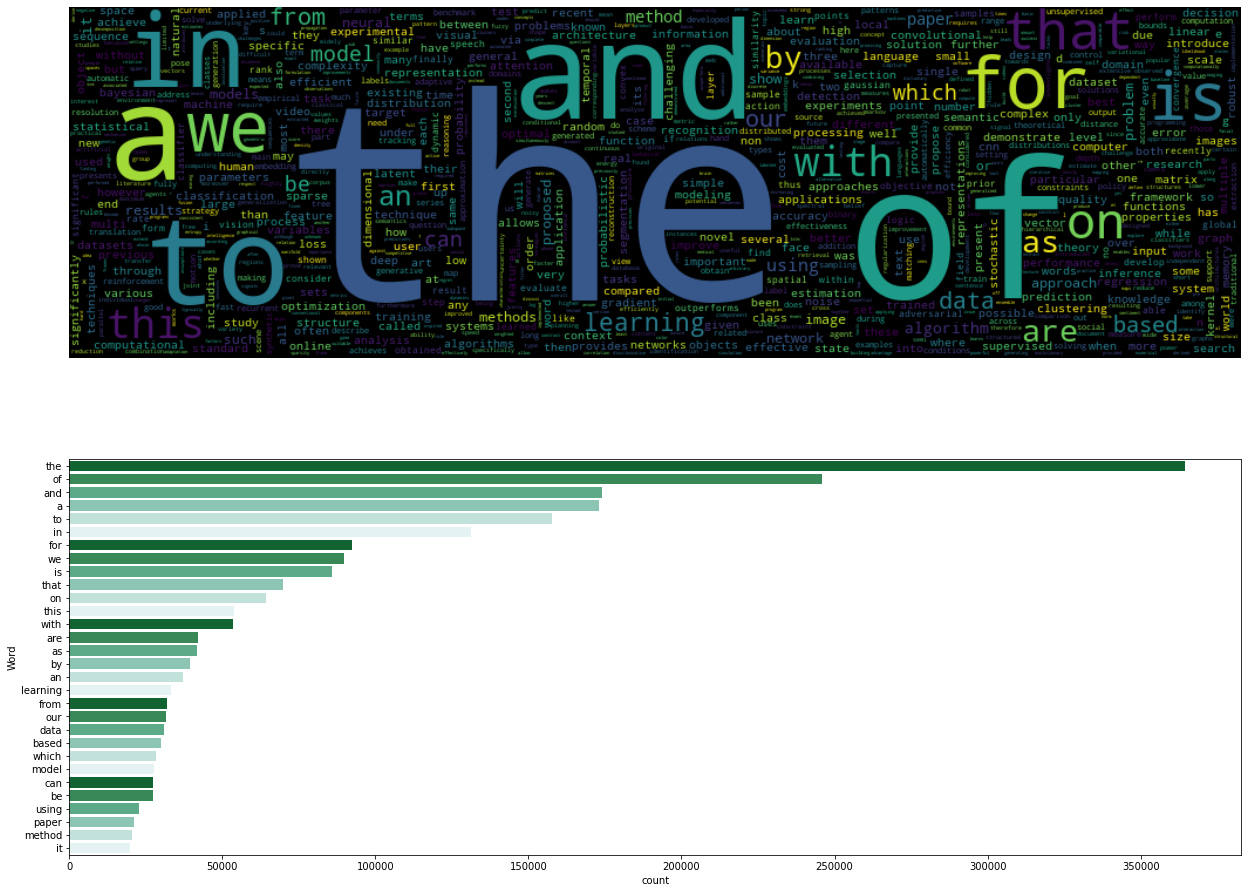

In [11]:
freq_words(df.soup, save=True, filename='wordcloud_with_stopwords')

### As it can be seen, stopwords are the most frequent words in our dataset, so it is important to not pay too much attention to them when training our neural network.
- By using nltk library, they can be easily removed from the dataset

In [12]:
print('English stopwords list:\n', '\n', stopwords.words('english'))

English stopwords list:
 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

### Stopwords tend to be the most frequent words in every text. After removing them, the result is quite different

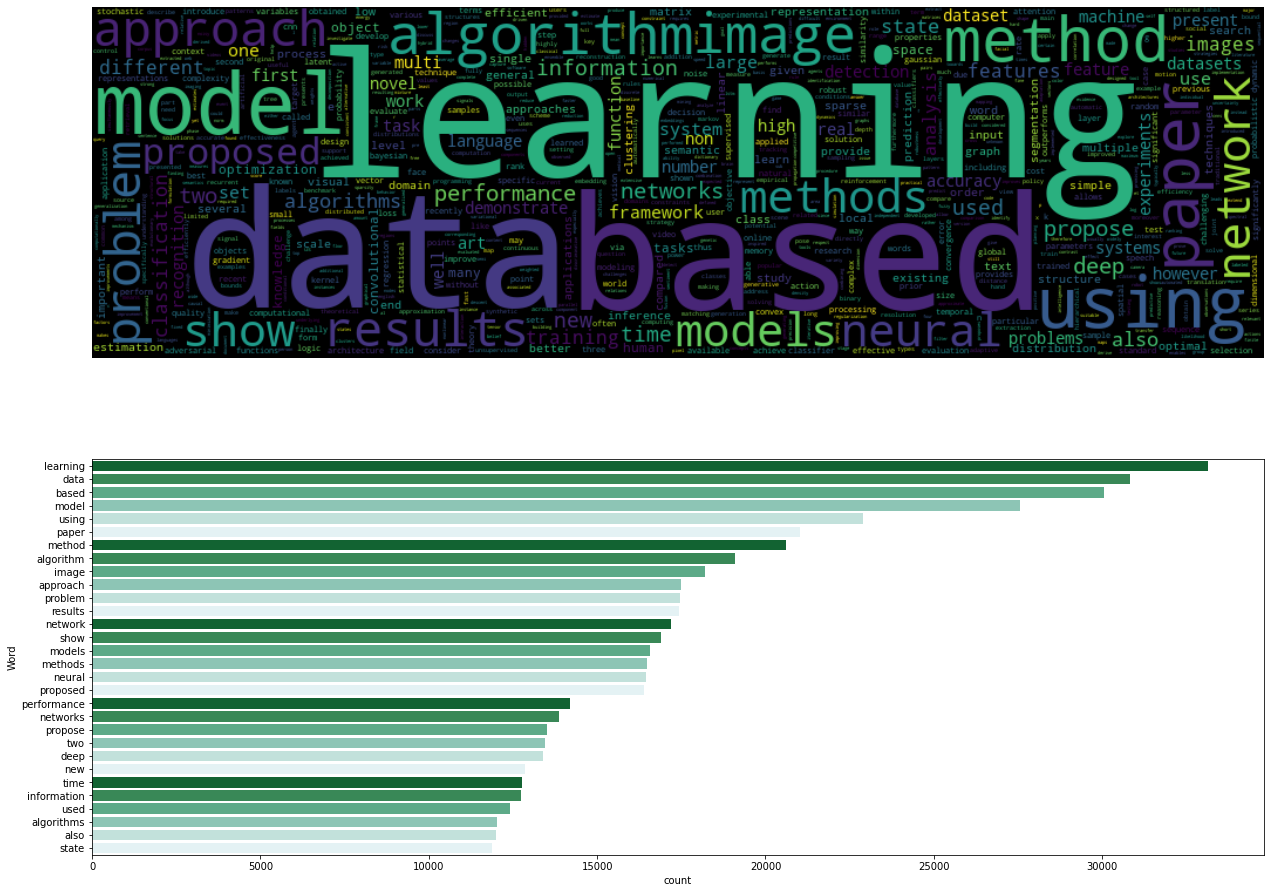

In [13]:
# Use remove_stop_words_function
df['soup'] = df['soup'].apply(lambda x: remove_stop_words(x))

# Plot 30 most frequent words without stopwords
freq_words(df['soup'], save=True, filename='wordcloud_wo_stopwords')

### As tags are going to be our target, it is interesting to see the role they play in the dataset

In [14]:
# Create a list with all tags
all_tags = sum(df['tag'], [])
tag_length = len(set(all_tags))

print(f'Tags have this length: {tag_length}')
print(f'\nHere is a list with 10 tags: {all_tags[1:10]}')

all_tags_dist = nltk.FreqDist(all_tags)
all_tags_df = pd.DataFrame({'tag': list(all_tags_dist.keys()), 'count': list(all_tags_dist.values())})

print('····················')
print(f'\nPlotting the 10 most common tags in the dataset')
all_tags_df.sort_values(by='count', ascending=False).head(10)

Tags have this length: 2167

Here is a list with 10 tags: ['cs.CL', 'cs.CV', 'cs.NE', 'stat.ML', 'cs.CL', 'cs.AI', 'cs.LG', 'cs.NE', 'stat.ML']
····················

Plotting the 10 most common tags in the dataset


,tag,count
2,cs.CV,13902
5,cs.LG,13734
0,cs.AI,10481
4,stat.ML,10241
1,cs.CL,6417
3,cs.NE,3817
21,cs.IR,1443
20,math.OC,1013
17,cs.RO,969
59,cs.LO,643


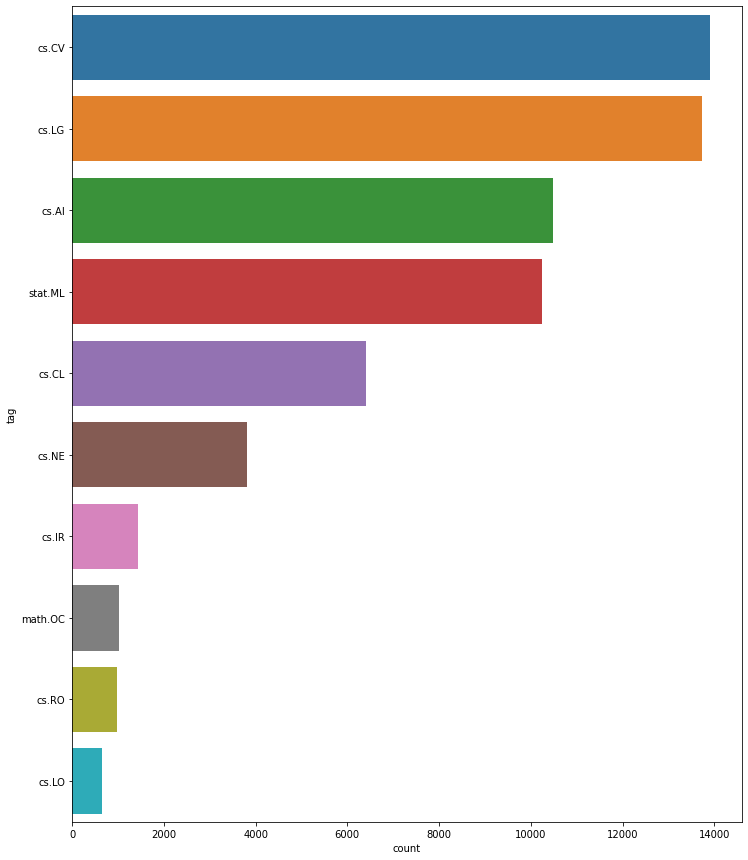

In [15]:
all_tags_plot = freq_tags(df=all_tags_df, n=10, save=True, filename='freq_tags', x='count', y='tag', sort_by='count')

In [16]:
# Save the most frequent words in a json file
save_freq_words(df=df, col='soup')

In [17]:
text_title = ''.join(titles for titles in df.clean_title)
text_summary = ''.join(summaries for summaries in df.clean_summary)
text_soup = ''.join(soups for soups in df.soup)
print('There are {} words in the title column'.format(len(text_title)))
print('\nThere are {} words in the summary column'.format(len(text_summary)))
print('\nThere are {} words in the soup column'.format(len(text_soup)))

There are 2785112 words in the title column

There are 41047780 words in the summary column

There are 34649072 words in the soup column


41000

### <a id='4'>4. Training the Model</a>

### Define both the features and target for the model
The tag is going to be the target label, so the model will have to predict the labels related to the text input

In [18]:
# X --> Feature
X = df['soup']

# y --> Target
y = df['tag'].values

# Check shapes
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (41000,)
y shape: (41000,)


In [19]:
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

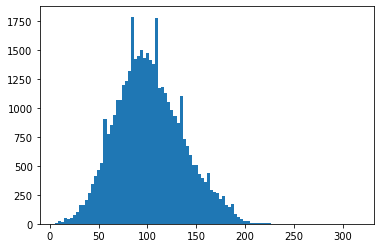

<Figure size 864x1080 with 0 Axes>

In [20]:
# Visualize sequence length. In order to decide the size of maximum length of the senteces, it is useful to check length distribution of the articles 
plot_sentence_distribution(X, save=True, filename='sentence-length-distribution')

### As we can see in the graph above, most texts are around 60 to 120 words long, and they are normally distributed (excepting some outliers). For this case, 80 would be the max length per padding.

In [21]:
# Assign maxlen variable
maxlen = 80

# Making sentences with maxlen size
pad_sequences(X, maxlen=maxlen)

array([[    0,  1016,   270, ...,   345,  2525,    68],
       [    0,     0,     0, ...,  2173,  2135,   111],
       [  245,  1581,   525, ...,   309,   304,    81],
       ...,
       [    0,   443,   114, ...,   814,  1510,     2],
       [    0,     0,     0, ...,  2138,  1432,  1415],
       [  509,   517,  1383, ...,  4268, 39553,   464]])

#### Now all sentences are 80 words long. The sentences with less length will fill missing values with zeros

In [22]:
# Check the size of vocabulary. This will be the input dimension for the embedding layer of the neural network.
vocab_size= len(tokenizer.word_index) + 1 #+1 for padding
print('Vocab size:', vocab_size)

Vocab size: 79592


### Now, the data is properly prepared, so it can be trained. Nevertheless, it is preferrable to train words with pretrained corpuses.
The purpose of doing this, is to capture and take into account factors as semantic and context of the words, as they are trained on vast datasets.

- Google provides the deepest source of pretrained word embeddings.
 - Google News is the corpus of this dataset. More info [here](https://gunjanagicha.medium.com/word-embeddings-ee718cd2b8b5)

In [23]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

C:\Users\leona/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [24]:
word_vectors = KeyedVectors.load_word2vec_format('\\Users\\leona\\gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', binary=True)

In [25]:
# By adding a string, we can see the relationship it has with other strings
word_vectors.most_similar('Obama')

[('Barack_Obama', 0.8036513328552246),
 ('President_Barack_Obama', 0.7878767848014832),
 ('McCain', 0.7555227875709534),
 ('Clinton', 0.7526832222938538),
 ('Illinois_senator', 0.74974524974823),
 ('Biden', 0.7485178709030151),
 ('Bush', 0.7348896861076355),
 ('Barack', 0.7290467023849487),
 ('White_House', 0.7151209115982056),
 ('elect_Barack_Obama', 0.6941337585449219)]

In [29]:
# Create the embedding matrix for the model
embedding_matrix = create_embedding_matrix(vocab_size=vocab_size)

In [30]:
def create_embedding_matrix(vocab_size):
    '''
    @leosanchezsoler
    This function is used to create the necessary embedding matrix that will be used for training the model
    Parameters:
        - vocab_size: an integer with the length of the vocabulary
    '''
    tokenizer = Tokenizer()
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in  tokenizer.word_index.items():
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab_size=vocab_size)

In [31]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Split the data in train and test sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.2)

In [33]:
def create_model():
	# create model
    model = Sequential()

    model.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix],  
    input_length=maxlen, trainable=False))

    model.add(Conv1D(activation='relu', filters=4, kernel_size=4))

    model.add(MaxPool1D())

    model.add(LSTM(units=128))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])

    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [36]:
%%time
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 80]
epochs = [2, 4, 6, 8]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'}), <class 'numpy.ndarray'>

In [27]:
del word_vectors 

In [28]:
# Set the max size of the array for each word
embedding_dim = 16

# Create a model in tensorflow
model = Sequential()
model.add(vectorize_layer)
model.add(layers.Embedding(vocab_size, embedding_dim, name='embedding'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(16, activation= 'relu'))
model.add(layers.Dense(1))

NameError: name 'vectorize_layer' is not defined

### Compile and train the model
Use tensorflow to visualize the metrics including loss and accuracy. Create a `tf.keras.callbacks.TensorBoard`


In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

In [21]:
model.compile(optimizer='adam',
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

In [22]:
history = model.fit(X, y,
                    epochs=200,
                    callbacks = [tensorboard_callback])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).